In [1]:
%config Completer.use_jedi = False

In [2]:
import os
import sys

import cv2

import scipy

import skimage
import skimage.measure
import skimage.filters
import skimage.segmentation

import imageio

import tabulate

import numpy as np

import tqdm.notebook as tqdm

from collections import defaultdict

from pydicom import dcmread
from pydicom import multival

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from IPython.display import clear_output, display

In [3]:
image = dcmread('./data/train/ID00183637202241995351650/52.dcm')

In [4]:
image

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.0.37492.1591342201.174020
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.0.37492.1591342201.174020
(0008, 0060) Modality                            CS: 'CT'
(

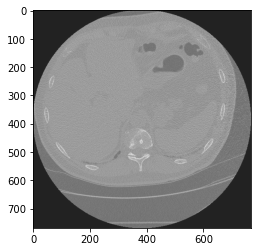

In [5]:
plt.imshow(image.pixel_array, cmap="gray")

In [6]:
def subplots_3d(nrows=1, ncols=1, figsize=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape([nrows, ncols])
    
    for idx in range(len(axes)):
        for jdx in range(len(axes[idx])):
            axes[idx][jdx].remove()
            axes[idx][jdx] = fig.add_subplot(nrows, ncols, 1 + idx * ncols + jdx,projection='3d')
            
    if nrows == 1:
        return fig, axes[0].tolist()
    return fig, axes.tolist()

def plot_3d(ax, image, stride, threshold=700, color="navy"):
    if isinstance(stride, (int, float)):
        stride = (stride, stride, stride)
    
    image = image[::stride[0], ::stride[1], ::stride[2]]
        
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces,_,_ = skimage.measure.marching_cubes(p, threshold)
    
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.2)
    mesh.set_facecolor(color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    
def sample_slices(images, n_slices, masks=None, alpha=0.2, cmap_name=None):
    nrows, ncols = n_slices // 4 + ((n_slices % 4) > 0), 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
    axes = np.array(axes).reshape(-1)

    idxs = np.sort(np.random.choice(np.arange(len(images)), nrows * ncols, replace=False))
    
    for ax, idx in zip(axes, idxs):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(images[idx], cmap=plt.get_cmap(cmap_name))
        if masks is not None:
            ax.imshow(masks[idx], alpha=alpha)
#             ax.imshow(masks[idx], alpha=alpha, cmap=plt.get_cmap(cmap_name))
        ax.grid(False)
        ax.set_title(f'Slice {idx}')
    plt.show()

In [7]:
def getkey(dcm, key):
    try:
        base_value = dcm[key]
    except:
        print(dcm.PatientID, dcm.InstanceNumber, key)
        return'KeyError'
    try:
        return base_value.value
    except:
        return base_value

In [8]:
def transform_to_hu(ct):
    slope = ct.RescaleSlope
    intercept = ct.RescaleIntercept
    image = ct.pixel_array.astype(np.int16)
    
    # some images has ousige pixel-values corresponging water
    # fix those images
    zero_cols = np.argwhere(np.sum(ct.pixel_array, axis=0) == 0).reshape(-1)
    zero_rows = np.argwhere(np.sum(ct.pixel_array, axis=1) == 0).reshape(-1)
    image[zero_rows, :] = -1000 - np.int16(intercept)
    image[:, zero_cols] = -1000 - np.int16(intercept)
    
    # convert to HU
    if slope != 1:
        image = (slope * image.astype(np.float64)).astype(np.int16)
    image += np.int16(intercept)
    
    # convert ouside pixel-values to air:
    # I'm using <= -1000 to be sure that other defaults are captured as well
    image[image <= -1000] = -1000
    
    return ct, image

In [9]:
def crop(image, center, size):
    return image.copy()[
        center[0] - size[0] // 2:center[0] + size[0] // 2
    ][:, center[1] - size[1] // 2:center[1] + size[1] // 2]

In [10]:
test_patients = sorted(os.listdir('./data/test/'))
train_patients = sorted(os.listdir('./data/train/'))

In [11]:
# test_ct = {
#     patient: [
#         dcmread(os.path.join('./data/test', patient, ct_file)) 
#         for ct_file in sorted(os.listdir(os.path.join('./data/test/', patient)))
#     ] for patient in test_patients
# }
# train_ct = {
#     patient: [
#         dcmread(os.path.join('./data/train', patient, ct_file)) 
#         for ct_file in os.listdir(os.path.join('./data/train/', patient))
#     ] for patient in train_patients
# }

In [12]:
transformations_in_train = defaultdict(lambda: lambda x: x, {
    'ID00014637202177757139317': lambda x: crop(x, (x.shape[0] // 2, x.shape[1] // 2), (512, 512)),
    'ID00067637202189903532242': lambda x: crop(x, (x.shape[0] // 2, x.shape[1] // 2), (512, 512)),
    'ID00086637202203494931510': lambda x: crop(x, (x.shape[0] // 2, x.shape[1] // 2), (512, 512)),
    'ID00094637202205333947361': lambda x: crop(x, (x.shape[0] // 2, x.shape[1] // 2), (512, 512)),
    'ID00122637202216437668965': lambda x: crop(x, (x.shape[0] // 2, x.shape[1] // 2), (512, 512)),
    'ID00240637202264138860065': lambda x: crop(x, (x.shape[0] // 2, x.shape[1] // 2), (512, 512)),
    'ID00419637202311204720264': lambda x: crop(x, (x.shape[0] // 2, x.shape[1] // 2), (512, 512))
})

# images that needs transformation in train set:
'''
    ID00115637202211874187958 1302 1302
    ID00288637202279148973731 632 632
    ID00358637202295388077032 632 632 
    ID00009637202177434476278 768 768
    ID00015637202177877247924 768 768
    ID00025637202179541264076 768 768
    ID00026637202179561894768 768 768
    ID00027637202179689871102 768 768
    ID00038637202182690843176 768 768
    ID00042637202184406822975 768 768
    ID00078637202199415319443 768 768
    ID00082637202201836229724 768 768
    ID00089637202204675567570 768 768
    ID00105637202208831864134 768 768
    ID00108637202209619669361 768 768
    ID00110637202210673668310 768 768
    ID00128637202219474716089 768 768
    ID00129637202219868188000 768 768
    ID00132637202222178761324 768 768
    ID00169637202238024117706 768 768
    ID00173637202238329754031 768 768
    ID00183637202241995351650 768 768
    ID00214637202257820847190 768 768
    ID00216637202257988213445 768 768
    ID00242637202264759739921 768 768
    ID00248637202266698862378 768 768
    ID00285637202278913507108 768 768
    ID00290637202279304677843 768 768
    ID00291637202279398396106 768 768
    ID00309637202282195513787 768 768
    ID00343637202287577133798 768 768
    ID00344637202287684217717 768 768
    ID00351637202289476567312 768 768
    ID00367637202296290303449 768 768
    ID00388637202301028491611 768 768
    ID00414637202310318891556 768 768
    ID00421637202311550012437 768 768
'''

transformations_in_test = defaultdict(lambda: lambda x: x, {
    'ID00419637202311204720264': lambda x: crop(x, (x.shape[0] // 2, x.shape[1] // 2), (512, 512))
})
    
# images that needs transformation in test set:
'''
    ID00421637202311550012437 768 768
'''

transformations = {
    'test': transformations_in_test,
    'train': transformations_in_train
}

In [13]:
def int16touint8(image):
    result = image.copy().astype(np.int16)
    result = result - result.min() + 10
    result = result / (result.max() + 10)
    return (result * 255.0).astype(np.uint8)

In [392]:
def segmentate_patient(mode, patient_n):
    base_path = os.path.join('./data', mode)
    patient = sorted(os.listdir(base_path))[patient_n]
    patient_path = os.path.join(base_path, patient)
    
    all_images, all_lungs, all_residuals, all_masks = [], [], [], []
    meta_data = {
        'InstanceNumber': [], 'SliceLocation': [], 'SliceThickness': [], 'PixelSpacing': [], 'PatientPosition': []
    }
    for idx, ct_name in enumerate(sorted(os.listdir(patient_path), key=lambda x: int(x.split('.')[0]))):
        ct_path = os.path.join(patient_path, ct_name)
        ct, ct_image = transform_to_hu(dcmread(ct_path))
        ct_image = transformations[mode][patient](ct_image)
        all_images.append(ct_image)
        
        lungs, residual, mask = segment_lungs(ct_image, patient_n, display=False)
        
        all_lungs.append(lungs)
        all_residuals.append(residual)        
        all_masks.append(mask)
        
        for key in meta_data.keys():
            meta_data[key].append(getkey(ct, key))
            
    return all_images, all_lungs, all_residuals, all_masks, meta_data

In [393]:
def merge(all_lungs, all_residuals, meta_data):
    def _issorted(_array):
        return np.all(_array[:-1] <= _array[1:]) or np.all(_array[:-1] >= _array[1:])
    
    SliceLocations = np.array(meta_data['SliceLocation'])
    InstanceNumbers = np.array(meta_data['InstanceNumber'])
    
#     assert _issorted(SliceLocations)
#     assert _issorted(InstanceNumbers)
    
    return np.stack(all_lungs), np.stack(all_residuals)

In [402]:
def _get_max_quantile(_array, _thresh=0.9):
    sorted_array = np.sort(_array)[::-1]
    thresh_idx =  np.argwhere((np.cumsum(sorted_array) / np.sum(_array) > _thresh)).reshape(-1)[0]
    return sorted_array[thresh_idx]

def segment_lungs(image, patient_n, display=False):
    def _contour_border_distance(_contour, shape):
        _distance = 2 * shape[0]
        _vdistance = 2 * shape[0]
        _hdistance = 2 * shape[0]
        for (point, ) in _contour:
            # image[point[1], point[0]]
            _distance = min(_distance, point[0], point[1], shape[1] - point[0], shape[0] - point[1])
            _vdistance = min(_vdistance, point[1], shape[0] - point[1])
            _hdistance = min(_hdistance, point[0], shape[1] - point[0])
        return _distance, _vdistance, _hdistance
    
    def _filter_contours(_mask):
        # Find all segments on the mask
        contours, hierarchy = cv2.findContours(_mask.astype(np.uint8), 1, 2)
        if len(contours) == 0:
            return _mask
        
        # Evaluate some statistics for each segment like area, perimeter, shape of bounding box, distance to borders
        countours_metrics = []
        for contour in contours:
            ((_, _), (horizontal_range, vertical_range), _) = cv2.minAreaRect(contour)

            countours_metrics.append(
                [
                    horizontal_range, vertical_range, 
                    cv2.arcLength(contour, True), cv2.contourArea(contour), 
                    _contour_border_distance(contour, image.shape)
                ]
            )
        
        # If a perimeter to small -- drop segment
        perimeter_thresh_1 = 2 * (2 * (_mask.shape[0] / 512.0) + 2 * (_mask.shape[1] / 512.0))
        # If a perimeter less than 10-th quantile -- drop segment
        perimeter_thresh_2 = np.quantile([_[2] for _ in countours_metrics], 0.1) if len(countours_metrics) > 7 else 0.0
        perimeter_thresh = max(perimeter_thresh_1, perimeter_thresh_2)

        # If an area to small -- drop segment
        area_thresh_1 = 6 * 6 * (_mask.shape[0] / 512.0)  * (_mask.shape[1] / 512.0)
        # If anarea less than 10-th quantile -- drop segment
        area_thresh_2 = np.quantile([_[3] for _ in countours_metrics], 0.1) if len(countours_metrics) > 7 else 0.0
        # Save the lagrest segments -- segments that overlap more than 95% of area of all segments
        area_thresh_3 = _get_max_quantile([_[3] for _ in countours_metrics], 0.95)
        area_thresh = max(area_thresh_1, area_thresh_2, area_thresh_3)
        
        # If a segment too close to the top or bottom border -- drop segment
        vdistance_to_border_thresh = 30.0 * (_mask.shape[0] / 512.0)
        # If a segment too close to the left or right border -- drop segment
        hdistance_to_border_thresh = 3.0 * (_mask.shape[1] / 512.0)
        
        for contour, (horizontal_range, vertical_range, perimeter, area, distances) in zip(contours, countours_metrics):
            distance, vdistance, hdistance = distances
            if_small_area = area < area_thresh
            if_small_high = vertical_range < 2.0
            if_small_width = horizontal_range < 2.0
            if_small_perimeter = perimeter < perimeter_thresh
            if_too_close_to_vborder = vdistance < vdistance_to_border_thresh
            if_too_close_to_hborder = hdistance < hdistance_to_border_thresh
            # If a segment too wide in compare to its height -- drop segment 
            if_too_long_1 = max(horizontal_range / vertical_range, vertical_range / horizontal_range) > 7.5
            # If a segment too wide and too flat -- drop segment 
            if_too_long_2 = horizontal_range > 0.5 * _mask.shape[0] and vertical_range < 0.15 * _mask.shape[1]
            # If a segment really too wide -- drope segment
            if_too_long_3 = horizontal_range > 0.87 * _mask.shape[0] or vertical_range > 0.87 * _mask.shape[1]
            
            if (
                if_small_area or 
                if_small_high or 
                if_small_width or 
                if_small_perimeter or
                if_too_close_to_vborder or
                if_too_close_to_hborder or
                if_too_long_1 or
                if_too_long_2 or 
                if_too_long_3
            ):        
                _mask = cv2.drawContours(
                    _mask.astype(np.uint8), [contour],
                    contourIdx=-1, color=(0), thickness=-1).astype(np.bool)
                if display:
                    print('Remove: ', (horizontal_range, vertical_range, perimeter, area, distances))
                    table = tabulate.tabulate([[
                        if_small_area,
                        if_small_high,
                        if_small_width,
                        if_small_perimeter,
                        if_too_close_to_vborder,
                        if_too_close_to_hborder,
                        if_too_long_1,
                        if_too_long_2,
                        if_too_long_3
                    ]], headers=[
                        'smll_area',
                        'smll_high',
                        'smll_width',
                        'smll_perimeter',
                        'close_to_vbrd',
                        'close_to_hbrd',
                        'long_1',
                        'long_2',
                        'long_3'
                    ])
                    print(table)
            else:
                if display:
                    print('Do not remove: ', (horizontal_range, vertical_range, perimeter, area, distances))
        
        return _mask

    thresh = -700
    thresh_mask = image <= thresh
    
    if patient_n >= 26:
        # Remove small holes and disconnections (Fixes patient №26. Need to check first 26 patients)
        # Bad for some patients with № < 26
        kernel = skimage.morphology.disk(3)
        thresh_mask = skimage.morphology.binary_closing(thresh_mask, selem=kernel)
    
    thresh_mask = skimage.segmentation.clear_border(thresh_mask)

    # Smooth image with
    lungs_mask = skimage.filters.median(thresh_mask)
    
    # Remove small holes and disconnections
    kernel = skimage.morphology.disk(7)
    lungs_mask = skimage.morphology.binary_closing(lungs_mask, selem=kernel)
    
    # Expand verticaly
    kernel = np.ones([3, 1], dtype=np.bool)
    lungs_mask = skimage.morphology.dilation(lungs_mask, selem=kernel)
    # Expand horizontaly
    kernel = np.ones([1, 7], dtype=np.bool)
    lungs_mask = skimage.morphology.dilation(lungs_mask, selem=kernel)
    lungs_mask = skimage.morphology.dilation(lungs_mask, selem=kernel)
    lungs_mask = skimage.morphology.dilation(lungs_mask, selem=kernel)
    
    # Remove some garbage
    lungs_mask = _filter_contours(lungs_mask)
    
    # Squeeze image horizontaly back
    kernel = np.ones([1, 7], dtype=np.bool)
    lungs_mask = skimage.morphology.erosion(lungs_mask, selem=kernel)
    lungs_mask = skimage.morphology.erosion(lungs_mask, selem=kernel)
    lungs_mask = skimage.morphology.erosion(lungs_mask, selem=kernel)
    # Squeeze image verticaly back
    kernel = np.ones([3, 1], dtype=np.bool)
    lungs_mask = skimage.morphology.erosion(lungs_mask, selem=kernel)
    
    # Fixes patient №55 (works well for all patients)
    kernel = np.ones([3, 1], dtype=np.bool)
    lungs_mask = skimage.morphology.erosion(lungs_mask, selem=kernel)
    # Remove small holes
    lungs_mask = scipy.ndimage.binary_fill_holes(lungs_mask)
    # Fixes patient №55 (works well for all patients)
    kernel = np.ones([3, 1], dtype=np.bool)
    lungs_mask = skimage.morphology.dilation(lungs_mask, selem=kernel)
    
    lungs = lungs_mask * image
    residual = (1.0 - lungs_mask) * image
    
    lungs[lungs == 0] = np.min(image)
    residual[residual == 0] = np.min(image)
    
    if display:
        fig, ax = plt.subplots(1, 5, figsize=(20, 15))

        ax[0].set_title('HU Image')
        ax[0].imshow(image, cmap='gray')
        ax[0].axis('off')

        ax[1].set_title('Thresholded Image')
        ax[1].imshow(thresh_mask, cmap='gray')
        ax[1].axis('off')

        ax[2].set_title('Lungs Mask')
        ax[2].imshow(lungs_mask)
        ax[2].axis('off')

        ax[3].set_title('Lungs Image')
        ax[3].imshow(lungs)
        ax[3].axis('off')
        
        ax[4].set_title('Residual Image')
        ax[4].imshow(residual)
        ax[4].axis('off')
    
    return lungs, residual, lungs_mask

In [403]:
params = {
    'base_threshold': -700,
    'min_vperimeter': 2, 'min_hperimeter': 2,
    'min_varea': 6, 'min_harea': 6,
    'min_quantile_contours': 7,
    'perimeter_quantile': 0.1,
    'area_quantile': 0.1, 'area_max_quantile': 0.95,
    'min_vdistance': 30.0, 'min_hdistance': 3.0,
    'min_hv_ratio': 7.5
}

'''
    ID00026637202179561894768 №11 -- strange images
    ID00076637202199015035026 №30 -- first 9 images need to be fixed
    ID00078637202199415319443 №32 -- two breathes
    ID00123637202217151272140 №51 -- very bag segmentation
    ID00126637202218610655908 №54 -- first 1 images need to be fixed
    ID00128637202219474716089 №56 -- strange images
    ID00129637202219868188000 №57 -- very bag segmentation
'''

train patient ID00007637202177411956430. number of slices: 27
Do not remove:  (6.0, 21.0, 52.24264061450958, 122.5, (91, 91, 237))
Remove:  (3.0, 20.0, 44.82842707633972, 59.0, (107, 107, 348))
  smll_area  smll_high    smll_width      smll_perimeter    close_to_vbrd    close_to_hbrd  long_1    long_2    long_3
-----------  -----------  ------------  ----------------  ---------------  ---------------  --------  --------  --------
          1  False        False                        0                0                0  False     False     False
Do not remove:  (13.096923828125, 40.98851776123047, 99.55634880065918, 298.5, (103, 103, 212))
Do not remove:  (52.768611907958984, 12.943243980407715, 138.04163002967834, 382.5, (104, 104, 258))
Do not remove:  (18.0, 26.0, 80.62741672992706, 397.0, (101, 101, 151))
Remove:  (2.0, 19.0, 42.0, 38.0, (125, 125, 259))
  smll_area  smll_high    smll_width      smll_perimeter    close_to_vbrd    close_to_hbrd  long_1    long_2    long_3
----------

Remove:  (5.0, 19.0, 46.82842707633972, 94.0, (75, 75, 161))
  smll_area  smll_high    smll_width      smll_perimeter    close_to_vbrd    close_to_hbrd  long_1    long_2    long_3
-----------  -----------  ------------  ----------------  ---------------  ---------------  --------  --------  --------
          1  False        False                        0                0                0  False     False     False
Remove:  (11.0, 24.0, 66.48528122901917, 237.0, (95, 95, 188))
  smll_area  smll_high    smll_width      smll_perimeter    close_to_vbrd    close_to_hbrd  long_1    long_2    long_3
-----------  -----------  ------------  ----------------  ---------------  ---------------  --------  --------  --------
          1  False        False                        0                0                0  False     False     False
Remove:  (24.0, 34.0, 108.52691149711609, 588.5, (91, 91, 149))
  smll_area  smll_high    smll_width      smll_perimeter    close_to_vbrd    close_to_hbrd  long

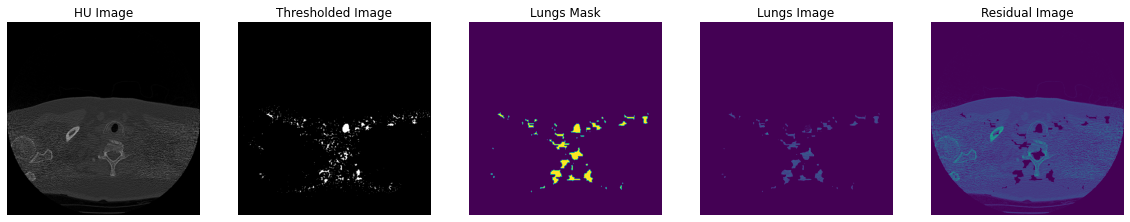

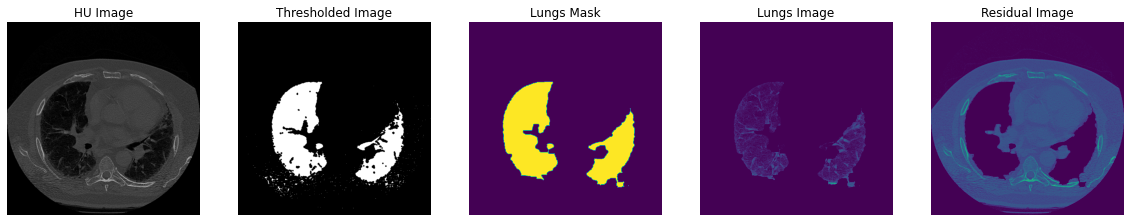

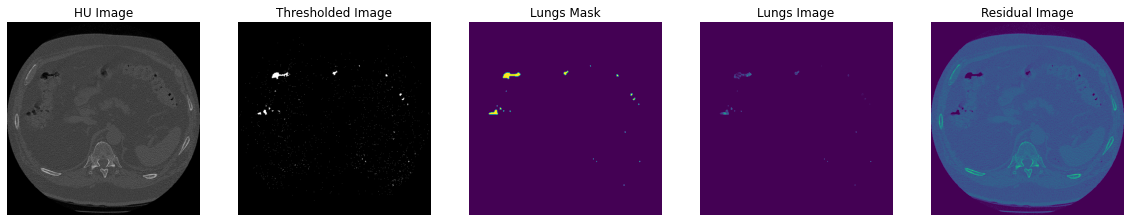

In [421]:
mode, patient_n = 'train', 57
all_images, all_lungs, all_residuals, all_masks, meta_data = segmentate_patient(mode, patient_n)
lungs_3d, residuals_3d = merge(all_lungs, all_residuals, meta_data)

print(f'{mode} patient {patient}. number of slices: {len(all_images)}')

_, __, ___ = segment_lungs(all_images[0], patient_n, display=True)
_, __, ___ = segment_lungs(all_images[len(all_images) // 2], patient_n, display=True)
_, __, ___ = segment_lungs(all_images[-1], patient_n, display=True)
# _, __, ___ = segment_lungs(all_images[24], patient_n, display=True)

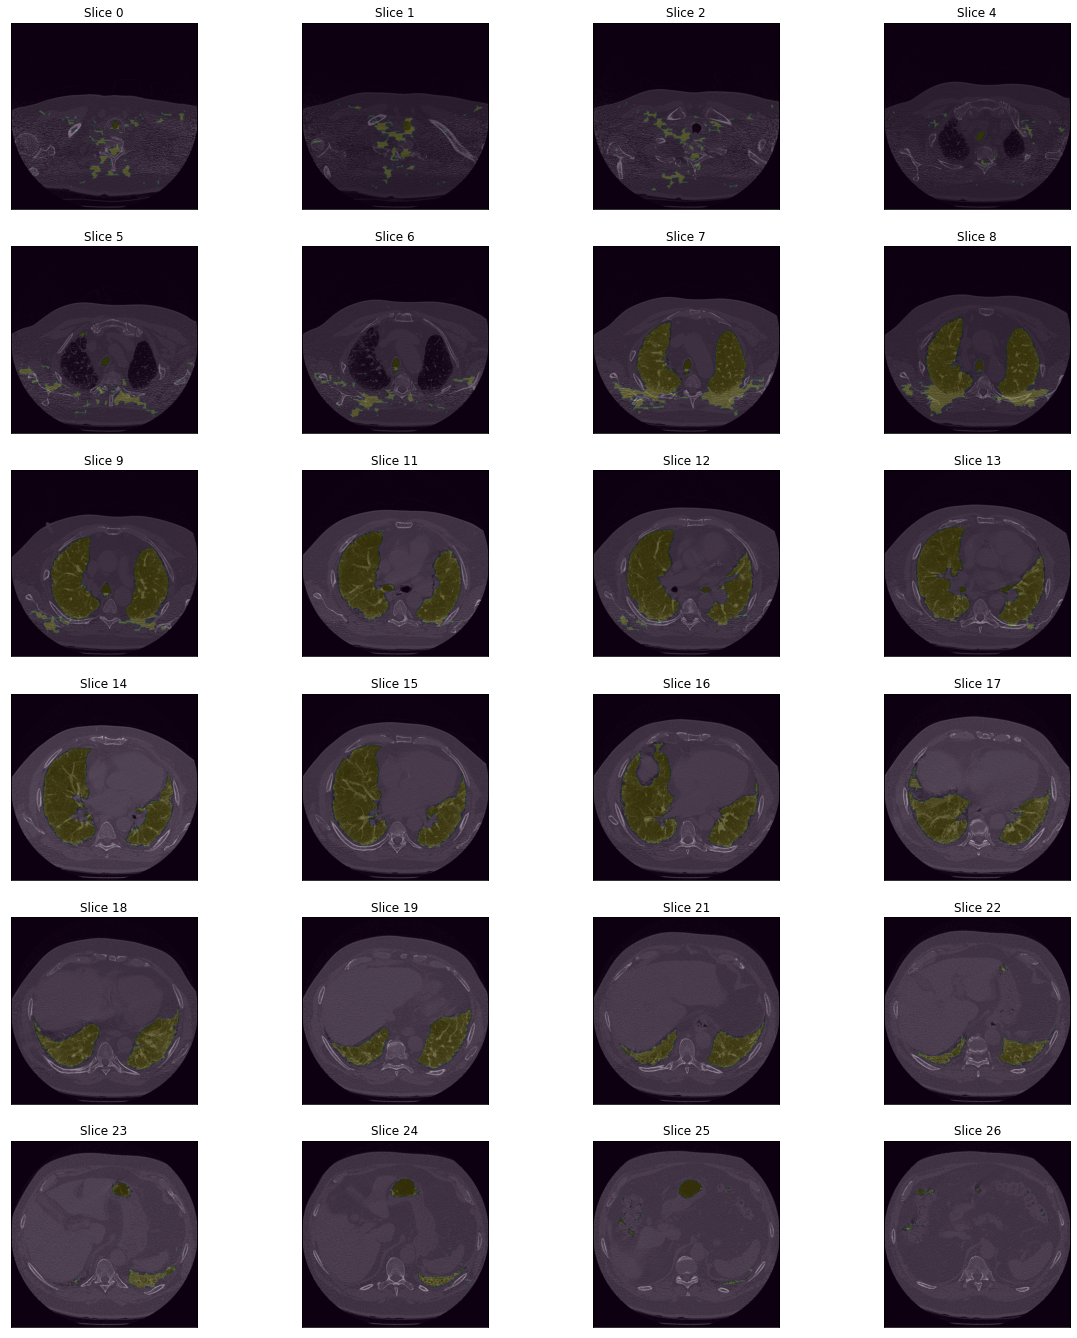

In [422]:
n_samples = len(all_images) // 2 if len(all_images) > 200 else len(all_images) - 3
sample_slices(all_images, n_samples, masks=all_masks, alpha=.2, cmap_name='gray')
# sample_slices(all_lungs, 28, masks=None, alpha=0.2, cmap_name=None)
# sample_slices(all_images[:28], 28, masks=None, alpha=0.2, cmap_name=None)
# sample_slices(all_masks[:28], 28, masks=None, alpha=0.2, cmap_name=None)

In [ ]:
# fig, axes = subplots_3d(1, 2, figsize=(15, 7))

# plot_3d(axes[0], lungs_3d, stride=1, threshold=-900)
# plot_3d(axes[1], residuals_3d, stride=1, threshold=700)

# plt.show()

In [ ]:
def resample(image, SliceThickness, PixelSpacing, new_spacing=(1.0, 1.0, 1.0)):
    # Determine current pixel spacing
    spacing = np.array([SliceThickness] + list(PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
lungs_3d_resampled, new_spacing = resample(lungs_3d, meta_data['SliceThickness'][-1], meta_data['PixelSpacing'][-1])

In [ ]:
lungs_3d.shape, lungs_3d_resampled.shape

In [ ]:
sample_slices(lungs_3d_resampled, 10)

In [ ]:
gif_writer = imageio.get_writer('./test.gif', mode='I', duration=0.1) 
for _ in tqdm.tqdm(range(1, 60)):
    ct, ct_image = transform_to_hu(dcmread(os.path.join('./data/train', 'ID00421637202311550012437', f'{_}.dcm')))
    lungs, lungs_mask = segment_lungs(ct_image)
    gif_writer.append_data(np.hstack([int16touint8(ct_image), int16touint8(lungs), int16touint8(lungs_mask)]))

In [ ]:
plt.imshow(lung_segment(ct_image)[0]); plt.show()
plt.imshow(lung_segment(ct_image)[1]); plt.show()

In [ ]:
mode = 'train'
base_path = os.path.join('./data', mode)

counter = defaultdict(int)
for patient in tqdm.tqdm(os.listdir(base_path)):
    patient_counter = defaultdict(int)
    patient_path = os.path.join(base_path, patient)
    for idx, ct_name in enumerate(sorted(os.listdir(patient_path), key=lambda x: int(x.split('.')[0]))):
        if idx > -1:
            ct_path = os.path.join(patient_path, ct_name)
            ct, ct_image = transform_to_hu(dcmread(ct_path))
            ct_image = transformations[mode][patient](ct_image)
            patient_counter[(getkey(ct, 'PixelSpacing')[0])] += 1
            
            del ct
    
    for key in patient_counter.keys():
        counter[key] += 1

In [ ]:
plt.hist(list(counter.keys()), bins=20)
plt.show()

In [ ]:
import pandas as pd

In [ ]:
test_data = pd.read_csv('./data/test.csv')
train_data = pd.read_csv('./data/train.csv')

In [ ]:
train_data

In [ ]:
train_patients_data = defaultdict(list)

for row in train_data.iterrows():
    train_patients_data[row[1]['Patient']].append((
        int(row[1]['Weeks']), 
        float(row[1]['FVC']),
        float(row[1]['Percent']),
        int(row[1]['Age']),
        row[1]['Sex'],
        row[1]['SmokingStatus']
    ))

In [ ]:
for patient, values in train_patients_data.items():
    weeks, fvcs, percents, ages, sex, smoking = zip(*values)
    plt.plot(weeks, sex)